<a href="https://colab.research.google.com/github/HMarcos/CienciaDeDados-Projeto2/blob/main/Projeto2_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificador imagens de mãos jogando pedra, papel e tesoura.

Trabalho referente à disciplina DCA-0131, Ciência de Dados, ministrada pelo professor Luiz Affonso Hederson Guedes de Oliveira.

Aplicação desenvolvida pelos discentes **Darlan de Castro e Marcos Henrique**, alunos do curso de Engenharia Computação da UFRN.

O presente classificador foi contruído usando o framework Tensorflow em conjunto com a sua API Keras.

Serão utilizados os conceitos de transfer learning (transferência de aprendizagem) e fine tuning (ajuste fino) para se obter bons resultados mesmo com um dataset limitado.

Link do dataset: [pedra Papel Tesoura](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors?hl=pt-br)

Link do tutorial do tensorflow sobre transfer learning: [Transfira o aprendizado e o ajuste fino](https://www.tensorflow.org/tutorials/images/transfer_learning)

## 1 - Examinando e compreendendo os dados.

In [ ]:
# Importando os principais pacotes
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf


from tensorflow.keras.preprocessing import image_dataset_from_directory

### 1.1 - Pré processamento de dados


In [ ]:
# Download dos dados
_TRAIN_URL = "https://storage.googleapis.com/download.tensorflow.org/data/rps.zip"
_TEST_URL = "https://storage.googleapis.com/download.tensorflow.org/data/rps-test-set.zip"

# Train dataset
train_path_to_zip = tf.keras.utils.get_file('/content/train.zip', origin=_TRAIN_URL, extract=True)
# Test dataset
test_path_to_zip = tf.keras.utils.get_file('/content/test.zip', origin=_TEST_URL, extract=True)

print(f"Train dataset zip path: {train_path_to_zip}")
print(f"Test dataset zip path: {test_path_to_zip}")

29523968/29516758 [==============================] - 1s 0us/step
Train dataset zip path: /content/train.zip
Test dataset zip path: /content/test.zip


In [ ]:
# Extrai as pastas e as imagens
!unzip test.zip
!unzip train.zip

In [ ]:
# Diretório do dataset de treino
train_dir = os.path.join(os.path.dirname(train_path_to_zip), 'rps')
# Diretório do dataset de validação
validation_dir = os.path.join(os.path.dirname(train_path_to_zip), 'rps-test-set')


In [ ]:
# Hiperparâmetros
BATCH_SIZE = 32
#IMG_SIZE = (300, 300)
IMG_SIZE = (224, 224)

In [ ]:
# Usando o image_dataset_from_directory para carregar o dataset de treino
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
print(f"Nome das classes: {train_dataset.class_names}")

Found 2520 files belonging to 3 classes.
Nome das classes: ['paper', 'rock', 'scissors']


In [ ]:
# Usando o image_dataset_from_directory para carregar o dataset de validação
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

print(f"Nome das classes: {validation_dataset.class_names}")

Found 372 files belonging to 3 classes.
Nome das classes: ['paper', 'rock', 'scissors']


Exibindo imagens do dataset de treino


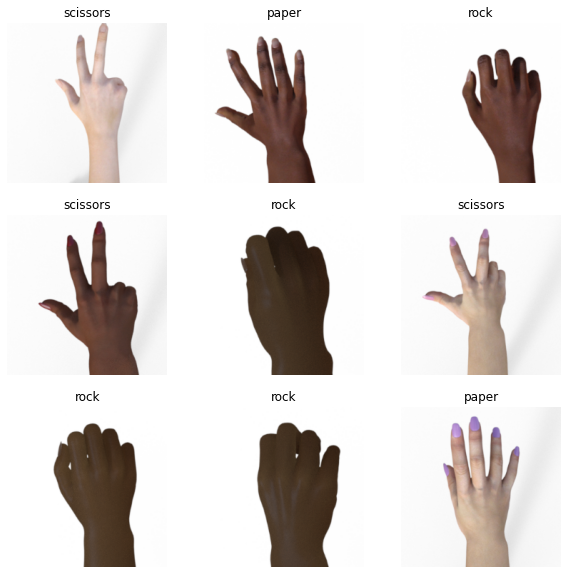

In [ ]:
# Nome das classes
class_names = train_dataset.class_names

# Exibindo imagens do dataset de treino usando o matplotlib
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Alocando o conjunto de testes a partir do de validação


In [ ]:
# Quantidade de batches para o teste de validação
val_batches = tf.data.experimental.cardinality(validation_dataset)
print(f"Quantidade original de batches de validação: {val_batches}")

# Alocando 50% das imagens de validação para teste
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

print(f'Número de batches de validação: {tf.data.experimental.cardinality(validation_dataset)}')
print(f'Number de batches de teste: {tf.data.experimental.cardinality(test_dataset)}')


Quantidade original de batches de validação: 12
Número de batches de validação: 6
Number de batches de teste: 6


### 1.2 Configurando o conjunto de dados para desempenho

Usa a pré-busca em buffer para carregar imagens do disco sem que o I / O se torne um bloqueio.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### 1.3 - Usando o aumento de dados
Quando não se tem um grande conjunto de dados de imagens, é uma boa prática introduzir artificialmente a diversidade da amostra aplicando transformações aleatórias, mas realistas, às imagens de treinamento, como rotação e inversão horizontal. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento e a reduzir o sobreajuste .


In [ ]:
# Aplicando o aumento de dados: flip da imagem horizontalmente e um rotações aleatórias
data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


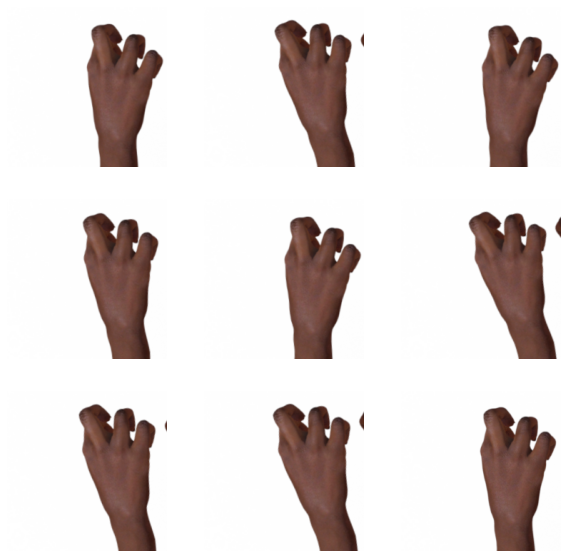

In [ ]:
# Visualizando o aumento de dados
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### 1.4 - Reescalando os pixels
Em um momento, será feito o download de `tf.keras.applications.MobileNetV2` para usar como modelo básico. Esse modelo espera valores de pixel em `[-1,1]` , mas neste ponto, os valores de pixel nas imagens estão em `[0-255]`. Para redimensioná-los, será usado o método de pré-processamento incluído no modelo.

In [ ]:
# Criando uma camada de pre-processamento para a reescala dos pixels
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Demonstrando o funcoinadmento
preprocess_input(np.array([127,255, 0]))

array([-0.00392157,  1.        , -1.        ], dtype=float32)

## 2 - Criando o model báscio a partir de convnets pré-treinadas
Será criado o modelo básico a partir do modelo **MobileNet V2** desenvolvido no **Google**. Ele foi pré-treinado no conjunto de dados **ImageNet**, um grande conjunto de dados que consiste em 1,4 milhões de imagens e 1000 classes. O **ImageNet** é um conjunto de dados de treinamento de pesquisa com uma ampla variedade de categorias. 

Primeiro, é preciso escolher qual camada do **MobileNet V2** será usada para extração de recursos. A última camada de classificação (no "topo", já que a maioria dos diagramas de modelos de aprendizado de máquina vai de baixo para cima) não é muito útil. Em vez disso, será seguido a prática comum de depender da última camada antes da operação de flatten. Essa camada é chamada de "camada de gargalo". Os recursos da camada de gargalo retêm mais generalidade em comparação com a camada final/superior.




Primeiramente, instanciea-se o modelo `MobileNet V2` pré-carregado com pesos treinados no ImageNet. Ao especificar o argumento `include_top = False`, carrega-se uma rede que não inclui as camadas de classificação no topo, o que é ideal para extração de recursos.

In [ ]:
# Cria o modelo base a partir do modelo pré-treinado MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# Verificando a saída do modelo base
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print("Formato de Saída do modelo base: {}".format(feature_batch.shape))

Formato de Saída do modelo base: (32, 7, 7, 1280)


## 3 - Extração de recursos
Nesta etapa, a base convolucional criada na etapa anterior será congelada para ser utilizada como um extrator de recurso. Além disso, adiciona-se um classificador ao final dele e treina-se o classificador de nível superior.

### 3.1 - Congelando a base convolucional
É importante congelar a base convolucional antes de compilar e treinar o modelo. Congelar (definindo `layer.trainable = False`) evita que os pesos em uma determinada camada sejam atualizados durante o treinamento. O **MobileNet V2** tem muitas camadas, portanto, definir o atributo de trainable como `False`, o modelo irá congelar todas essas camadas.


In [ ]:
# Congelando as camadas do modelo base
base_model.trainable = False

Modelo Base

In [ ]:
# Arquitetura do modelo base
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Note que todos os parâmetros do modelo base estão configurados como não-treináveis. Assim, os seus pesos durante o treinamento não serão atualizados.


### 3.2 - Adicionando o header de classificação
Para gerar previsões a partir do bloco de recursos, se faz a média sobre as matrizes 10x10, usando uma camada `tf.keras.layers.GlobalAveragePooling2D` para converter os recursos em um único vetor de 1280 elementos por imagem.


In [ ]:
# Transformando os dados em um array de apenas uma dimensão
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print("Avarage Pooling formato: {}".format(feature_batch_average.shape))

Avarage Pooling formato: (32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
# Criando o modelo
inputs = tf.keras.Input(shape=(224, 224, 3))
#inputs = tf.keras.Input(shape=(300, 300, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
#x = base_model.output
#x = global_average_layer(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3)(x)

print(outputs.shape)

model = tf.keras.Model(inputs, outputs)

(None, 3)


Compilando o modelo

In [ ]:
# Taxa de aprendizagem
base_learning_rate = 0.0001

# Otimizador
#opt = tf.keras.optimizers.Adam(lr=base_learning_rate)

# Compilando o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [ ]:
# Sumário do modelo
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               327936

In [ ]:
# Avaliação inicial sem o treinamento do modelo
loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


6/6 [==============================] - 5s 155ms/step - loss: 1.5843 - accuracy: 0.3911
initial loss: 1.59
initial accuracy: 0.37


## 4 - Treinando o modelo

In [ ]:
# Quantidade de épocas iniciais
initial_epochs = 10
# Treinamento do modelo
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
79/79 [==============================] - 17s 167ms/step - loss: 0.4265 - accuracy: 0.8512 - val_loss: 0.3863 - val_accuracy: 0.9000
Epoch 2/10
79/79 [==============================] - 14s 158ms/step - loss: 0.0919 - accuracy: 0.9869 - val_loss: 0.3227 - val_accuracy: 0.9000
Epoch 3/10
79/79 [==============================] - 13s 158ms/step - loss: 0.0446 - accuracy: 0.9972 - val_loss: 0.3203 - val_accuracy: 0.8667
Epoch 4/10
79/79 [==============================] - 14s 161ms/step - loss: 0.0311 - accuracy: 0.9968 - val_loss: 0.3139 - val_accuracy: 0.8500
Epoch 5/10
79/79 [==============================] - 14s 161ms/step - loss: 0.0204 - accuracy: 0.9996 - val_loss: 0.2196 - val_accuracy: 0.9278
Epoch 6/10
79/79 [==============================] - 14s 160ms/step - loss: 0.0150 - accuracy: 0.9996 - val_loss: 0.3289 - val_accuracy: 0.8278
Epoch 7/10
79/79 [==============================] - 14s 160ms/step - loss: 0.0114 - accuracy: 0.9996 - val_loss: 0.2303 - val_accuracy: 0.9000

### 4.1 - Curvas de Aprendizado


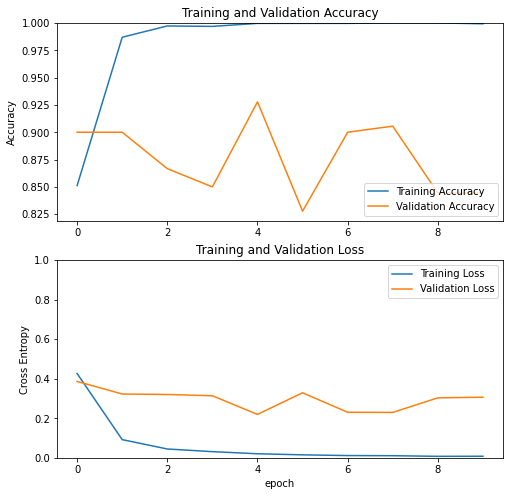

In [ ]:
# Curvas de aprendizado durante o treinamento e a validação das imagens
# Acurácia
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Gráfico da acurácia
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# Gráfico do loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 5 - Fine Tuning (Ajuste Fino)
Na parte extração de recursos, apenas algumas camadas sobre um modelo básico MobileNet V2 foram treinadas. Os pesos da rede pré-treinada não foram atualizados durante o treinamento.

Uma maneira de aumentar ainda mais o desempenho é treinar (ou "ajustar") os pesos das camadas superiores do modelo pré-treinado junto com o treinamento do classificador adicionado. O processo de treinamento forçará os pesos a serem ajustados de mapas de recursos genéricos para recursos associados especificamente ao conjunto de dados.

Além disso, deve-se tentar ajustar um pequeno número de camadas superiores em vez de todo o modelo MobileNet. Na maioria das redes convolucionais, quanto mais alta a camada, mais especializada ela é. As primeiras camadas aprendem recursos muito simples e genéricos que se generalizam para quase todos os tipos de imagens. Conforme se sobe, os recursos são cada vez mais específicos para o conjunto de dados no qual o modelo foi treinado. O objetivo do ajuste fino é adaptar esses recursos especializados para trabalhar com o novo conjunto de dados, em vez de substituir o aprendizado genérico

### 5.1 - Descongelar as camadas superiores
Tudo que se precisa fazer é descongelar o `base_model` e definir as camadas inferiores como não treináveis. Em seguida, deve-se recompilar o modelo (necessário para que essas alterações tenham efeito) e retomar o treinamento.

In [ ]:
# Descongelando o modelo base
base_model.trainable = True

In [ ]:
# Quantas camadas há no modelo base
print("Número de camadas no modelo base: ", len(base_model.layers))

# Faça o ajuste fino a partir dessa camada
fine_tune_at = 100

# Congele todas as camadas anteriores a camanda `fine_tune_at` 
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Número de camadas no modelo base:  154


### 5.2 - Recompilando o modelo
Como se está treinando um modelo muito maior e deseja readaptar os pesos pré-treinados, é importante usar uma taxa de aprendizado mais baixa neste estágio. Caso contrário, o modelo pode ajustar muito rapidamente.

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
# Resumo do modelo
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               327936

### 5.3 - Continuar a treinar o modelo
Esta estapa possui o objetivo de melhorar a precisão do modelo

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
79/79 [==============================] - 22s 191ms/step - loss: 0.0233 - accuracy: 0.9933 - val_loss: 0.1004 - val_accuracy: 0.9444
Epoch 11/20
79/79 [==============================] - 15s 176ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.4527 - val_accuracy: 0.8500
Epoch 12/20
79/79 [==============================] - 15s 177ms/step - loss: 2.8194e-04 - accuracy: 1.0000 - val_loss: 0.1989 - val_accuracy: 0.9000
Epoch 13/20
79/79 [==============================] - 15s 176ms/step - loss: 6.7376e-05 - accuracy: 1.0000 - val_loss: 0.6391 - val_accuracy: 0.8611
Epoch 14/20
79/79 [==============================] - 15s 177ms/step - loss: 3.8494e-05 - accuracy: 1.0000 - val_loss: 0.2300 - val_accuracy: 0.9167
Epoch 15/20
79/79 [==============================] - 15s 176ms/step - loss: 7.7067e-05 - accuracy: 1.0000 - val_loss: 0.5320 - val_accuracy: 0.8667
Epoch 16/20
79/79 [==============================] - 15s 176ms/step - loss: 6.2512e-06 - accuracy: 1.0000 - val_loss: 0.

In [ ]:
# Dados do ajuste fino
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

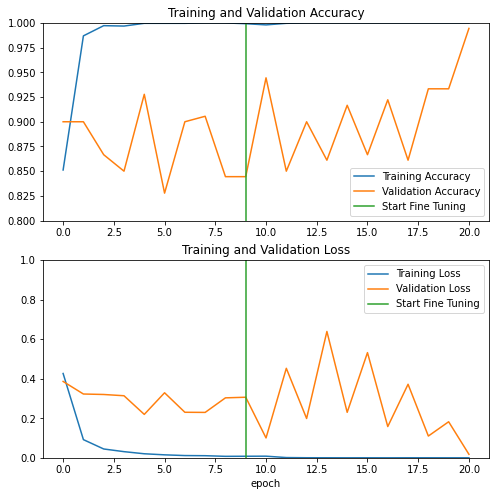

In [ ]:
# Gráficos após o ajuste fino
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 5.4 - Avaliando o modelo

In [ ]:
finalLoss, finalAccuracy = model.evaluate(test_dataset)
print('Test accuracy :', finalAccuracy)

6/6 [==============================] - 2s 113ms/step - loss: 0.0188 - accuracy: 1.0000
Test accuracy : 1.0


Aplicando ao dataset de teste

Labels:
 [0 2 1 2 1 0 0 0 1 2 1 1 1 1 0 0 2 2 2 0 0 2 1 2 0 0 1 1 0 2 1 1]


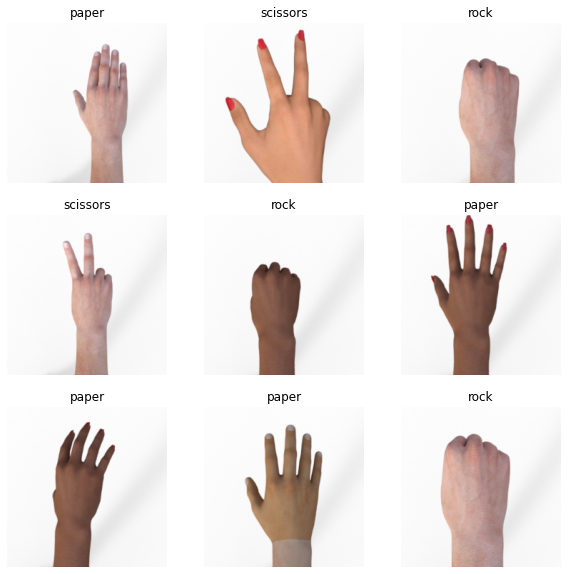

In [ ]:
#Recuperando um lote de imagens do dataset de teste
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a sigmoid since our model returns logits
predictions = tf.nn.softmax(predictions)

#print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  index = np.argmax(predictions[i])
  plt.imshow(image_batch[i].astype("uint8"))
  #plt.title(class_names[predictions[i]])
  plt.title(class_names[index])
  plt.axis("off")